In [1]:
import torch
from torch.utils.data import DataLoader, random_split
import Models.Get_data as Gd
import numpy as np
import random
from Models.CAE_LSTM import CAE_LSTM_seq2seq
from torchinfo import summary
import pickle
import os
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn
import os

In [2]:
latent_space = 20
window_size = 10
step_size = 3
batch_size = 5

# 获取目录路径
dirpath = os.path.dirname(f'/home/wl4023/github repos/IRP/predict result/Latent space {latent_space}/a.txt')
# 创建目录（如果不存在）
os.makedirs(dirpath, exist_ok=True)

In [3]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(66)  # 你可以选择任意一个数字作为种子
# 启用浮点数异常检测
# torch.autograd.set_detect_anomaly(True)
directory = '/home/wl4023/data/Sibo_22Mar2024'
folders = [os.path.join(directory, f, 'hessian_') for f in os.listdir(directory) if f.startswith('case_')]

In [4]:
# 检查是否有 GPU 可用
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

# 检查 GPU 的数量
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

# 获取每个 GPU 的名称
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# 设置默认使用的 GPU 设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

GPU is available
Number of GPUs available: 1
GPU 0: NVIDIA GeForce RTX 4060 Laptop GPU
Using device: cuda:0


In [5]:
with open('/home/wl4023/github repos/IRP/preprocessor.pkl', 'rb') as f:
    preprocessor = pickle.load(f)
print(preprocessor.mean, preprocessor.std)

6.95707893371582 9.811119079589844


In [6]:
dataset, length = Gd.get_all_nodes(folders[:-1])
dataset = np.expand_dims(dataset[:, :, 0], axis=1)

dataset = torch.tensor(dataset, dtype=torch.float32)
dataset = Gd.segment_data_torch(dataset, length, window_size, step_size)

data = Gd.MyDataset(dataset[:, 0:5, :, :], dataset[:, -5:, :, :])
train_set, val_set = random_split(data, [0.8, 0.2])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)

## train

In [7]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_true, y_pred):
        return torch.sqrt(self.mse(y_true, y_pred))
    
class NRMSE(nn.Module):
    def __init__(self, total_dataset):
        super(NRMSE, self).__init__()
        self.rmse = RMSELoss()
        self.factor = total_dataset.max()-total_dataset.min()

    def forward(self, y_true, y_pred):
        return self.rmse(y_true, y_pred)/self.factor

In [8]:
def train(model, train_loader, val_loader, criterion, metric, optimizer, device=device, epochs=30, seq_len=5):
    train_NRMSELoss_list = []
    train_RMSELoss_list = []

    val_NRMSELoss_list = []
    val_RMSELoss_list = []

    min_loss = 10000
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_metric = 0
        for x, y in tqdm(train_loader):
            input = preprocessor.transform(x).to(device)
            x = x.to(device)
            optimizer.zero_grad()
            predict = model(x, seq_len)
            loss = criterion(input, predict)
            loss.backward()
            optimizer.step()

            recon_predict = preprocessor.inverse_transform(predict.cpu())
            # print(recon_predict.max(), train_loss, len(train_loader))
            train_loss += criterion(y, recon_predict).item()
            train_metric += metric(y, recon_predict).item()
            # print(train_loss, len(train_loader))
        
        train_loss /= len(train_loader)
        # print(train_loss, len(train_loader))
        train_metric /= len(train_loader)
        train_RMSELoss_list.append(train_loss)
        train_NRMSELoss_list.append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_metric = 0
            for x, y in val_loader:
                input = preprocessor.transform(x).to(device)
                x = x.to(device)
                predict = model(x, seq_len)

                recon_predict = preprocessor.inverse_transform(predict.cpu())
                val_loss += criterion(y, recon_predict).item()
                val_metric += metric(y, recon_predict).item()
    
            val_loss /= len(val_loader)
            val_metric /= len(val_loader)
            val_RMSELoss_list.append(val_loss)
            val_NRMSELoss_list.append(val_metric)

        print(f'Epoch {epoch + 1}/{epochs}, train Loss: {train_loss}, NRMSE_train_loss: {train_metric}, val Loss: {val_loss}, NRMSE_val_loss: {val_metric}')
        
        if min_loss >= val_metric:
            min_loss = val_metric
            torch.save(model.state_dict(), f'/home/wl4023/github repos/IRP/predict result/Latent space {latent_space}/CAE_LSTM.pth')

    return train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list

In [9]:
# Define the weights initialization function
def initialize_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

In [10]:
model = CAE_LSTM_seq2seq(latent_space, 100)
# model.apply(initialize_weights)
summary(model, input_data=(train_set[0:5][0], 5))

Layer (type:depth-idx)                   Output Shape              Param #
CAE_LSTM_seq2seq                         [5, 5, 1, 97149]          --
├─CAE_LSTM_encoder: 1-1                  [5, 100]                  --
│    └─Encoder: 2-1                      [5, 20]                   --
│    │    └─Conv1d: 3-1                  [5, 4, 97149]             36
│    │    └─Dropout: 3-2                 [5, 4, 97149]             --
│    │    └─MaxPool1d: 3-3               [5, 4, 19429]             --
│    │    └─Conv1d: 3-4                  [5, 4, 19429]             132
│    │    └─Dropout: 3-5                 [5, 4, 19429]             --
│    │    └─MaxPool1d: 3-6               [5, 4, 3885]              --
│    │    └─Conv1d: 3-7                  [5, 1, 3885]              33
│    │    └─LeakyReLU: 3-8               [5, 1, 3885]              --
│    │    └─Dropout: 3-9                 [5, 1, 3885]              --
│    │    └─MaxPool1d: 3-10              [5, 1, 777]               --
│    │    └─Ad

In [11]:
model = model.to(device)
optimizer = optim.Adam(model.parameters())
criterion = RMSELoss()
metric = NRMSE(dataset)
train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list = train(model,
                                                                                         train_loader,
                                                                                         val_loader,
                                                                                         criterion,
                                                                                         metric,
                                                                                         optimizer,
                                                                                         device=device,
                                                                                         epochs=50,
                                                                                         seq_len=5)

100%|██████████| 144/144 [00:19<00:00,  7.31it/s]


Epoch 1/50, train Loss: 7.088711591230498, NRMSE_train_loss: 0.13623640595728326, val Loss: 8.763132360246447, NRMSE_val_loss: 0.1684167349918021


100%|██████████| 144/144 [00:19<00:00,  7.31it/s]


Epoch 2/50, train Loss: 5.902952060103416, NRMSE_train_loss: 0.11344755143444571, val Loss: 7.38483550813463, NRMSE_val_loss: 0.1419275469250149


100%|██████████| 144/144 [00:18<00:00,  7.67it/s]


Epoch 3/50, train Loss: 5.044535514381197, NRMSE_train_loss: 0.09694983059954312, val Loss: 6.6256323787901135, NRMSE_val_loss: 0.12733658734295103


100%|██████████| 144/144 [00:18<00:00,  7.63it/s]


Epoch 4/50, train Loss: 4.887455583446556, NRMSE_train_loss: 0.09393094547299875, val Loss: 6.421631647480859, NRMSE_val_loss: 0.12341594054467148


100%|██████████| 144/144 [00:18<00:00,  7.71it/s]


Epoch 5/50, train Loss: 4.306466509898503, NRMSE_train_loss: 0.08276504293705027, val Loss: 5.753177185853322, NRMSE_val_loss: 0.1105690606766277


100%|██████████| 144/144 [00:15<00:00,  9.10it/s]


Epoch 6/50, train Loss: 3.9924802862935596, NRMSE_train_loss: 0.07673060988438213, val Loss: 4.804379946655697, NRMSE_val_loss: 0.09233433277242714


100%|██████████| 144/144 [00:16<00:00,  8.90it/s]


Epoch 7/50, train Loss: 3.752319527996911, NRMSE_train_loss: 0.07211501297489223, val Loss: 4.73823121521208, NRMSE_val_loss: 0.09106303451375829


100%|██████████| 144/144 [00:18<00:00,  7.65it/s]


Epoch 8/50, train Loss: 3.6445781050456896, NRMSE_train_loss: 0.07004435360431671, val Loss: 5.2128187153074474, NRMSE_val_loss: 0.10018402782993184


100%|██████████| 144/144 [00:18<00:00,  7.62it/s]


Epoch 9/50, train Loss: 3.49611656450563, NRMSE_train_loss: 0.06719110352504584, val Loss: 4.653573910395305, NRMSE_val_loss: 0.08943602380653222


100%|██████████| 144/144 [00:18<00:00,  7.62it/s]


Epoch 10/50, train Loss: 3.5320223453972073, NRMSE_train_loss: 0.06788116892696255, val Loss: 4.21684330701828, NRMSE_val_loss: 0.08104259396592776


100%|██████████| 144/144 [00:18<00:00,  7.66it/s]


Epoch 11/50, train Loss: 3.3074335729082427, NRMSE_train_loss: 0.06356484633094321, val Loss: 4.5088890592257185, NRMSE_val_loss: 0.08665535805953874


100%|██████████| 144/144 [00:18<00:00,  7.70it/s]


Epoch 12/50, train Loss: 3.1692566809554896, NRMSE_train_loss: 0.060909254683388606, val Loss: 6.125056458844079, NRMSE_val_loss: 0.11771612738569577


100%|██████████| 144/144 [00:16<00:00,  8.48it/s]


Epoch 13/50, train Loss: 3.1976813330418534, NRMSE_train_loss: 0.06145554154904352, val Loss: 3.9003167351086936, NRMSE_val_loss: 0.07495933843569623


100%|██████████| 144/144 [00:18<00:00,  7.77it/s]


Epoch 14/50, train Loss: 3.0873898598882885, NRMSE_train_loss: 0.059335874005531274, val Loss: 3.667185035016802, NRMSE_val_loss: 0.07047883131437832


100%|██████████| 144/144 [00:18<00:00,  7.63it/s]


Epoch 15/50, train Loss: 3.0838491001890764, NRMSE_train_loss: 0.05926782496842659, val Loss: 4.079518304930793, NRMSE_val_loss: 0.07840337480107944


100%|██████████| 144/144 [00:18<00:00,  7.72it/s]


Epoch 16/50, train Loss: 3.051953682468997, NRMSE_train_loss: 0.05865483375317934, val Loss: 3.9149836235576205, NRMSE_val_loss: 0.07524121790710422


100%|██████████| 144/144 [00:18<00:00,  7.93it/s]


Epoch 17/50, train Loss: 3.3883024570014744, NRMSE_train_loss: 0.06511904759746459, val Loss: 4.152638018131256, NRMSE_val_loss: 0.07980864608867301


100%|██████████| 144/144 [00:15<00:00,  9.38it/s]


Epoch 18/50, train Loss: 3.099619569049941, NRMSE_train_loss: 0.05957091391448759, val Loss: 3.501994914478726, NRMSE_val_loss: 0.06730407797214058


100%|██████████| 144/144 [00:15<00:00,  9.50it/s]


Epoch 19/50, train Loss: 3.0918267286486096, NRMSE_train_loss: 0.059421145227841206, val Loss: 3.7806945741176605, NRMSE_val_loss: 0.0726603465154767


100%|██████████| 144/144 [00:15<00:00,  9.44it/s]


Epoch 20/50, train Loss: 3.0219102340439954, NRMSE_train_loss: 0.05807743525494718, val Loss: 3.828810155391693, NRMSE_val_loss: 0.07358506984180874


100%|██████████| 144/144 [00:19<00:00,  7.28it/s]


Epoch 21/50, train Loss: 3.064166098833084, NRMSE_train_loss: 0.058889541529222496, val Loss: 3.5424308478832245, NRMSE_val_loss: 0.06808120793559486


100%|██████████| 144/144 [00:17<00:00,  8.30it/s]


Epoch 22/50, train Loss: 3.0534696872863503, NRMSE_train_loss: 0.05868396957197951, val Loss: 4.0046653217739525, NRMSE_val_loss: 0.07696479165719615


100%|██████████| 144/144 [00:17<00:00,  8.35it/s]


Epoch 23/50, train Loss: 2.965310783849822, NRMSE_train_loss: 0.05698966282782041, val Loss: 3.9685184955596924, NRMSE_val_loss: 0.07627009362396267


100%|██████████| 144/144 [00:17<00:00,  8.33it/s]


Epoch 24/50, train Loss: 3.0163535003860793, NRMSE_train_loss: 0.05797064153011888, val Loss: 3.625303261809879, NRMSE_val_loss: 0.06967391446232796


100%|██████████| 144/144 [00:17<00:00,  8.31it/s]


Epoch 25/50, train Loss: 3.0283423538009324, NRMSE_train_loss: 0.05820105268826915, val Loss: 3.3124810026751623, NRMSE_val_loss: 0.06366185155800647


100%|██████████| 144/144 [00:16<00:00,  8.62it/s]


Epoch 26/50, train Loss: 3.0207462078995175, NRMSE_train_loss: 0.058055063890707165, val Loss: 3.4624634087085724, NRMSE_val_loss: 0.0665443307823605


100%|██████████| 144/144 [00:15<00:00,  9.32it/s]


Epoch 27/50, train Loss: 2.967551985134681, NRMSE_train_loss: 0.05703273609591027, val Loss: 3.5126282142268286, NRMSE_val_loss: 0.06750843756728703


100%|██████████| 144/144 [00:15<00:00,  9.39it/s]


Epoch 28/50, train Loss: 2.9833599970572524, NRMSE_train_loss: 0.05733654661647355, val Loss: 3.280925449397829, NRMSE_val_loss: 0.06305539282038808


100%|██████████| 144/144 [00:15<00:00,  9.50it/s]


Epoch 29/50, train Loss: 3.0297575216326447, NRMSE_train_loss: 0.058228250541206866, val Loss: 3.460401197274526, NRMSE_val_loss: 0.06650469772931603


100%|██████████| 144/144 [00:15<00:00,  9.54it/s]


Epoch 30/50, train Loss: 3.0439344892899194, NRMSE_train_loss: 0.058500714690631464, val Loss: 3.9803659915924072, NRMSE_val_loss: 0.07649778905842039


100%|██████████| 144/144 [00:15<00:00,  9.53it/s]


Epoch 31/50, train Loss: 3.0243491994010077, NRMSE_train_loss: 0.058124309250464044, val Loss: 3.5262510743406086, NRMSE_val_loss: 0.06777025231470664


100%|██████████| 144/144 [00:15<00:00,  9.55it/s]


Epoch 32/50, train Loss: 2.963653653860092, NRMSE_train_loss: 0.05695781492007276, val Loss: 3.823251509004169, NRMSE_val_loss: 0.07347823876059717


100%|██████████| 144/144 [00:15<00:00,  9.55it/s]


Epoch 33/50, train Loss: 3.0036828319231668, NRMSE_train_loss: 0.05772712705139485, val Loss: 3.3732567760679455, NRMSE_val_loss: 0.06482988802923097


100%|██████████| 144/144 [00:15<00:00,  9.54it/s]


Epoch 34/50, train Loss: 3.8037815561725035, NRMSE_train_loss: 0.07310405011392301, val Loss: 3.5295340485042996, NRMSE_val_loss: 0.06783334667690927


100%|██████████| 144/144 [00:15<00:00,  9.55it/s]


Epoch 35/50, train Loss: 3.0540273189544678, NRMSE_train_loss: 0.05869468661128647, val Loss: 3.432213409079446, NRMSE_val_loss: 0.06596296197838253


100%|██████████| 144/144 [00:15<00:00,  9.51it/s]


Epoch 36/50, train Loss: 3.0282083973288536, NRMSE_train_loss: 0.058198478202232055, val Loss: 3.383848617474238, NRMSE_val_loss: 0.06503345036051339


100%|██████████| 144/144 [00:15<00:00,  9.53it/s]


Epoch 37/50, train Loss: 3.0130298390156693, NRMSE_train_loss: 0.057906765089784235, val Loss: 3.339149230056339, NRMSE_val_loss: 0.06417438222302331


100%|██████████| 144/144 [00:15<00:00,  9.54it/s]


Epoch 38/50, train Loss: 3.0418929279678397, NRMSE_train_loss: 0.05846147819991327, val Loss: 3.457204911443922, NRMSE_val_loss: 0.06644326929623882


100%|██████████| 144/144 [00:15<00:00,  9.53it/s]


Epoch 39/50, train Loss: 2.928174664162927, NRMSE_train_loss: 0.05627595179248601, val Loss: 3.4317203760147095, NRMSE_val_loss: 0.06595348721990983


100%|██████████| 144/144 [00:15<00:00,  9.55it/s]


Epoch 40/50, train Loss: 2.9913052411542997, NRMSE_train_loss: 0.05748924468126562, val Loss: 3.4774214492903814, NRMSE_val_loss: 0.06683180600197779


100%|██████████| 144/144 [00:15<00:00,  9.55it/s]


Epoch 41/50, train Loss: 2.9811899902092085, NRMSE_train_loss: 0.057294841506518424, val Loss: 3.3951765298843384, NRMSE_val_loss: 0.06525115891256267


100%|██████████| 144/144 [00:15<00:00,  9.54it/s]


Epoch 42/50, train Loss: 3.007543272856209, NRMSE_train_loss: 0.057801319920043975, val Loss: 3.470357484287686, NRMSE_val_loss: 0.06669604571329223


100%|██████████| 144/144 [00:15<00:00,  9.54it/s]


Epoch 43/50, train Loss: 3.0261055678129196, NRMSE_train_loss: 0.05815806466206494, val Loss: 3.2395681308375464, NRMSE_val_loss: 0.06226055546560221


100%|██████████| 144/144 [00:15<00:00,  9.38it/s]


Epoch 44/50, train Loss: 2.9848851333889694, NRMSE_train_loss: 0.05736585800898158, val Loss: 3.7329481508996754, NRMSE_val_loss: 0.07174271888410051


100%|██████████| 144/144 [00:18<00:00,  7.64it/s]


Epoch 45/50, train Loss: 2.9665844755040274, NRMSE_train_loss: 0.05701414160689132, val Loss: 3.527530802620782, NRMSE_val_loss: 0.06779484761257966


100%|██████████| 144/144 [00:17<00:00,  8.12it/s]


Epoch 46/50, train Loss: 3.073182552638981, NRMSE_train_loss: 0.05906282685464248, val Loss: 3.324029955599043, NRMSE_val_loss: 0.06388380854494041


100%|██████████| 144/144 [00:17<00:00,  8.14it/s]


Epoch 47/50, train Loss: 2.9593736160960464, NRMSE_train_loss: 0.056875557632237256, val Loss: 3.3758194347222648, NRMSE_val_loss: 0.06487913874702321


100%|██████████| 144/144 [00:17<00:00,  8.23it/s]


Epoch 48/50, train Loss: 2.971579157229927, NRMSE_train_loss: 0.05711013335450035, val Loss: 3.249429633220037, NRMSE_val_loss: 0.06245008142044147


100%|██████████| 144/144 [00:17<00:00,  8.24it/s]


Epoch 49/50, train Loss: 3.0390750898255243, NRMSE_train_loss: 0.05840732285933983, val Loss: 3.5776430699560375, NRMSE_val_loss: 0.06875794349859159


100%|██████████| 144/144 [00:17<00:00,  8.20it/s]


Epoch 50/50, train Loss: 2.9339519300394588, NRMSE_train_loss: 0.056386983727053225, val Loss: 3.584808462195926, NRMSE_val_loss: 0.06889565340760681


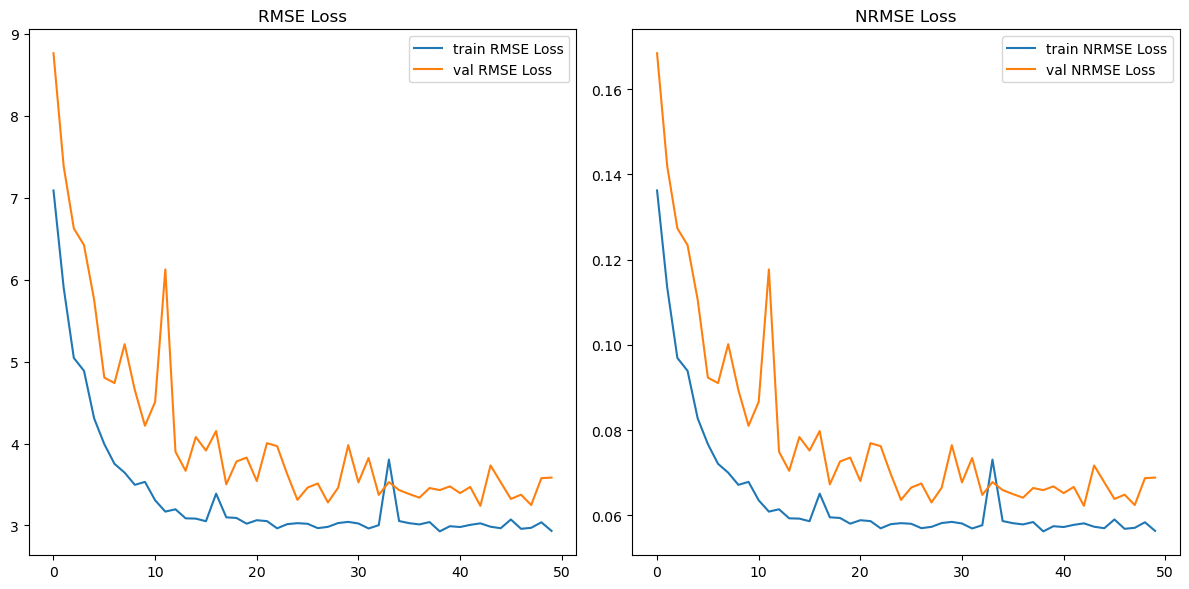

In [12]:
fig1, axs = plt.subplots(1, 2, figsize=(12, 6))
train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list
axs[0].plot(train_RMSELoss_list, label='train RMSE Loss')
axs[0].plot(val_RMSELoss_list, label='val RMSE Loss')
axs[0].set_title("RMSE Loss")
axs[0].legend()

axs[1].plot(train_NRMSELoss_list, label='train NRMSE Loss')
axs[1].plot(val_NRMSELoss_list, label='val NRMSE Loss')
axs[1].set_title("NRMSE Loss")
axs[1].legend()

plt.tight_layout()  # 调整布局以防止重叠
# plt.savefig('CAE_train_loss.png')  # 你可以更改文件名或格式
plt.savefig(f'/home/wl4023/github repos/IRP/predict result/Latent space {latent_space}/CAE_LSTM_train_loss.png')
plt.show()

In [13]:
dataset, length = Gd.get_all_nodes(folders[-1:])
dataset = np.expand_dims(dataset[:, :, 0], axis=1)

dataset = torch.tensor(dataset, dtype=torch.float32)
dataset = Gd.segment_data_torch(dataset, length, window_size, step_size)

test_set = Gd.MyDataset(dataset[:, 0:5, :, :], dataset[:, -5:, :, :])

test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

In [14]:
model = CAE_LSTM_seq2seq(latent_space, 100)
state_dict = torch.load(f'/home/wl4023/github repos/IRP/predict result/Latent space {latent_space}/CAE_LSTM.pth')
model.load_state_dict(state_dict)

criterion = RMSELoss()
metric = NRMSE(dataset)

In [15]:
test_RMSELoss_list = []
test_NRMSELoss_list = []

recon_predict_list = []

model.eval()
with torch.no_grad():
    test_loss = 0
    test_metric = 0
    for x, y in test_loader:
        input = preprocessor.transform(x).to(device)
        predict = model(x, 5)

        recon_predict = preprocessor.inverse_transform(predict)

        recon_predict_list.append(recon_predict)
        test_RMSELoss_list.append(criterion(y, recon_predict).item())
        test_NRMSELoss_list.append(metric(y, recon_predict).item())

        test_loss += criterion(y, recon_predict).item()
        test_metric += metric(y, recon_predict).item()

recon_predict_list = torch.cat(recon_predict_list, dim=0).numpy()


test_rmse = np.array(test_RMSELoss_list)
test_nrmse = np.array(test_NRMSELoss_list)

test_loss = test_rmse.mean()
test_metric = test_nrmse.mean()
print(f'Ave test loss: {test_loss}, Ave test metric: {test_metric}')

Ave test loss: 2.908387960926179, Ave test metric: 0.16539250650713522


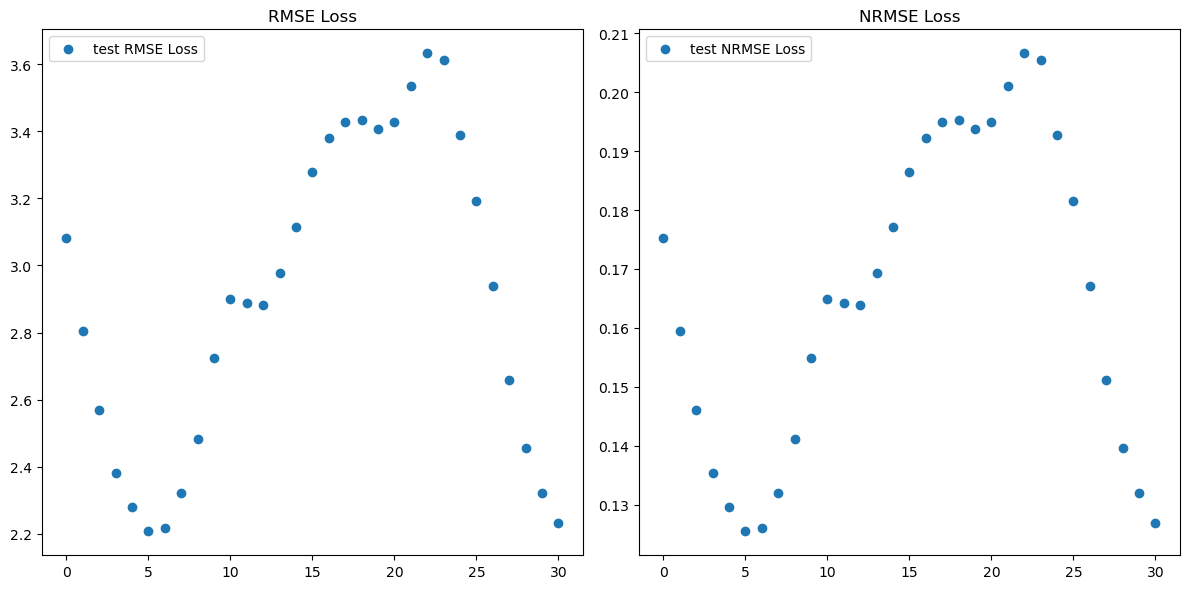

In [16]:
x = np.arange(0, len(test_loader))


# 保存数组到 .npy 文件
# np.save('test_rmse.npy', test_rmse)
# np.save('test_nrmse.npy', test_nrmse)

fig1, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(x, test_rmse, label='test RMSE Loss')
axs[0].set_title("RMSE Loss")
axs[0].legend()

axs[1].scatter(x, test_nrmse, label='test NRMSE Loss')
axs[1].set_title("NRMSE Loss")
axs[1].legend()


plt.tight_layout()  # 调整布局以防止重叠

# plt.savefig('CAE_test_loss.png')  # 你可以更改文件名或格式
plt.savefig(f'/home/wl4023/github repos/IRP/predict result/Latent space {latent_space}/CAE_LSTM_test_loss.png')

plt.show()

In [17]:
def draw_pic(x, y, predict, coords):
    fig, axs = plt.subplots(3, 5, figsize=(30, 18))
    for i in range(axs.shape[-1]):
        axs[0][i].scatter(coords[:,0],coords[:,1],s = 5, c=x[i, :, :], cmap='bwr')
        axs[0][i].set_title(f'Origin Input {i+1}')

    for i in range(axs.shape[-1]):
        axs[1][i].scatter(coords[:,0],coords[:,1],s = 5, c=y[i, :, :], cmap='bwr')
        axs[1][i].set_title(f'Real Output {i+1}')

    for i in range(axs.shape[-1]):
        axs[2][i].scatter(coords[:,0],coords[:,1],s = 5, c=predict[i, :, :], cmap='bwr')
        axs[2][i].set_title(f'Real Output {i+1}')

    plt.savefig(f'/home/wl4023/github repos/IRP/predict result/Latent space {latent_space}/CAE_LSTM_output.png')
    plt.show()
    plt.close()

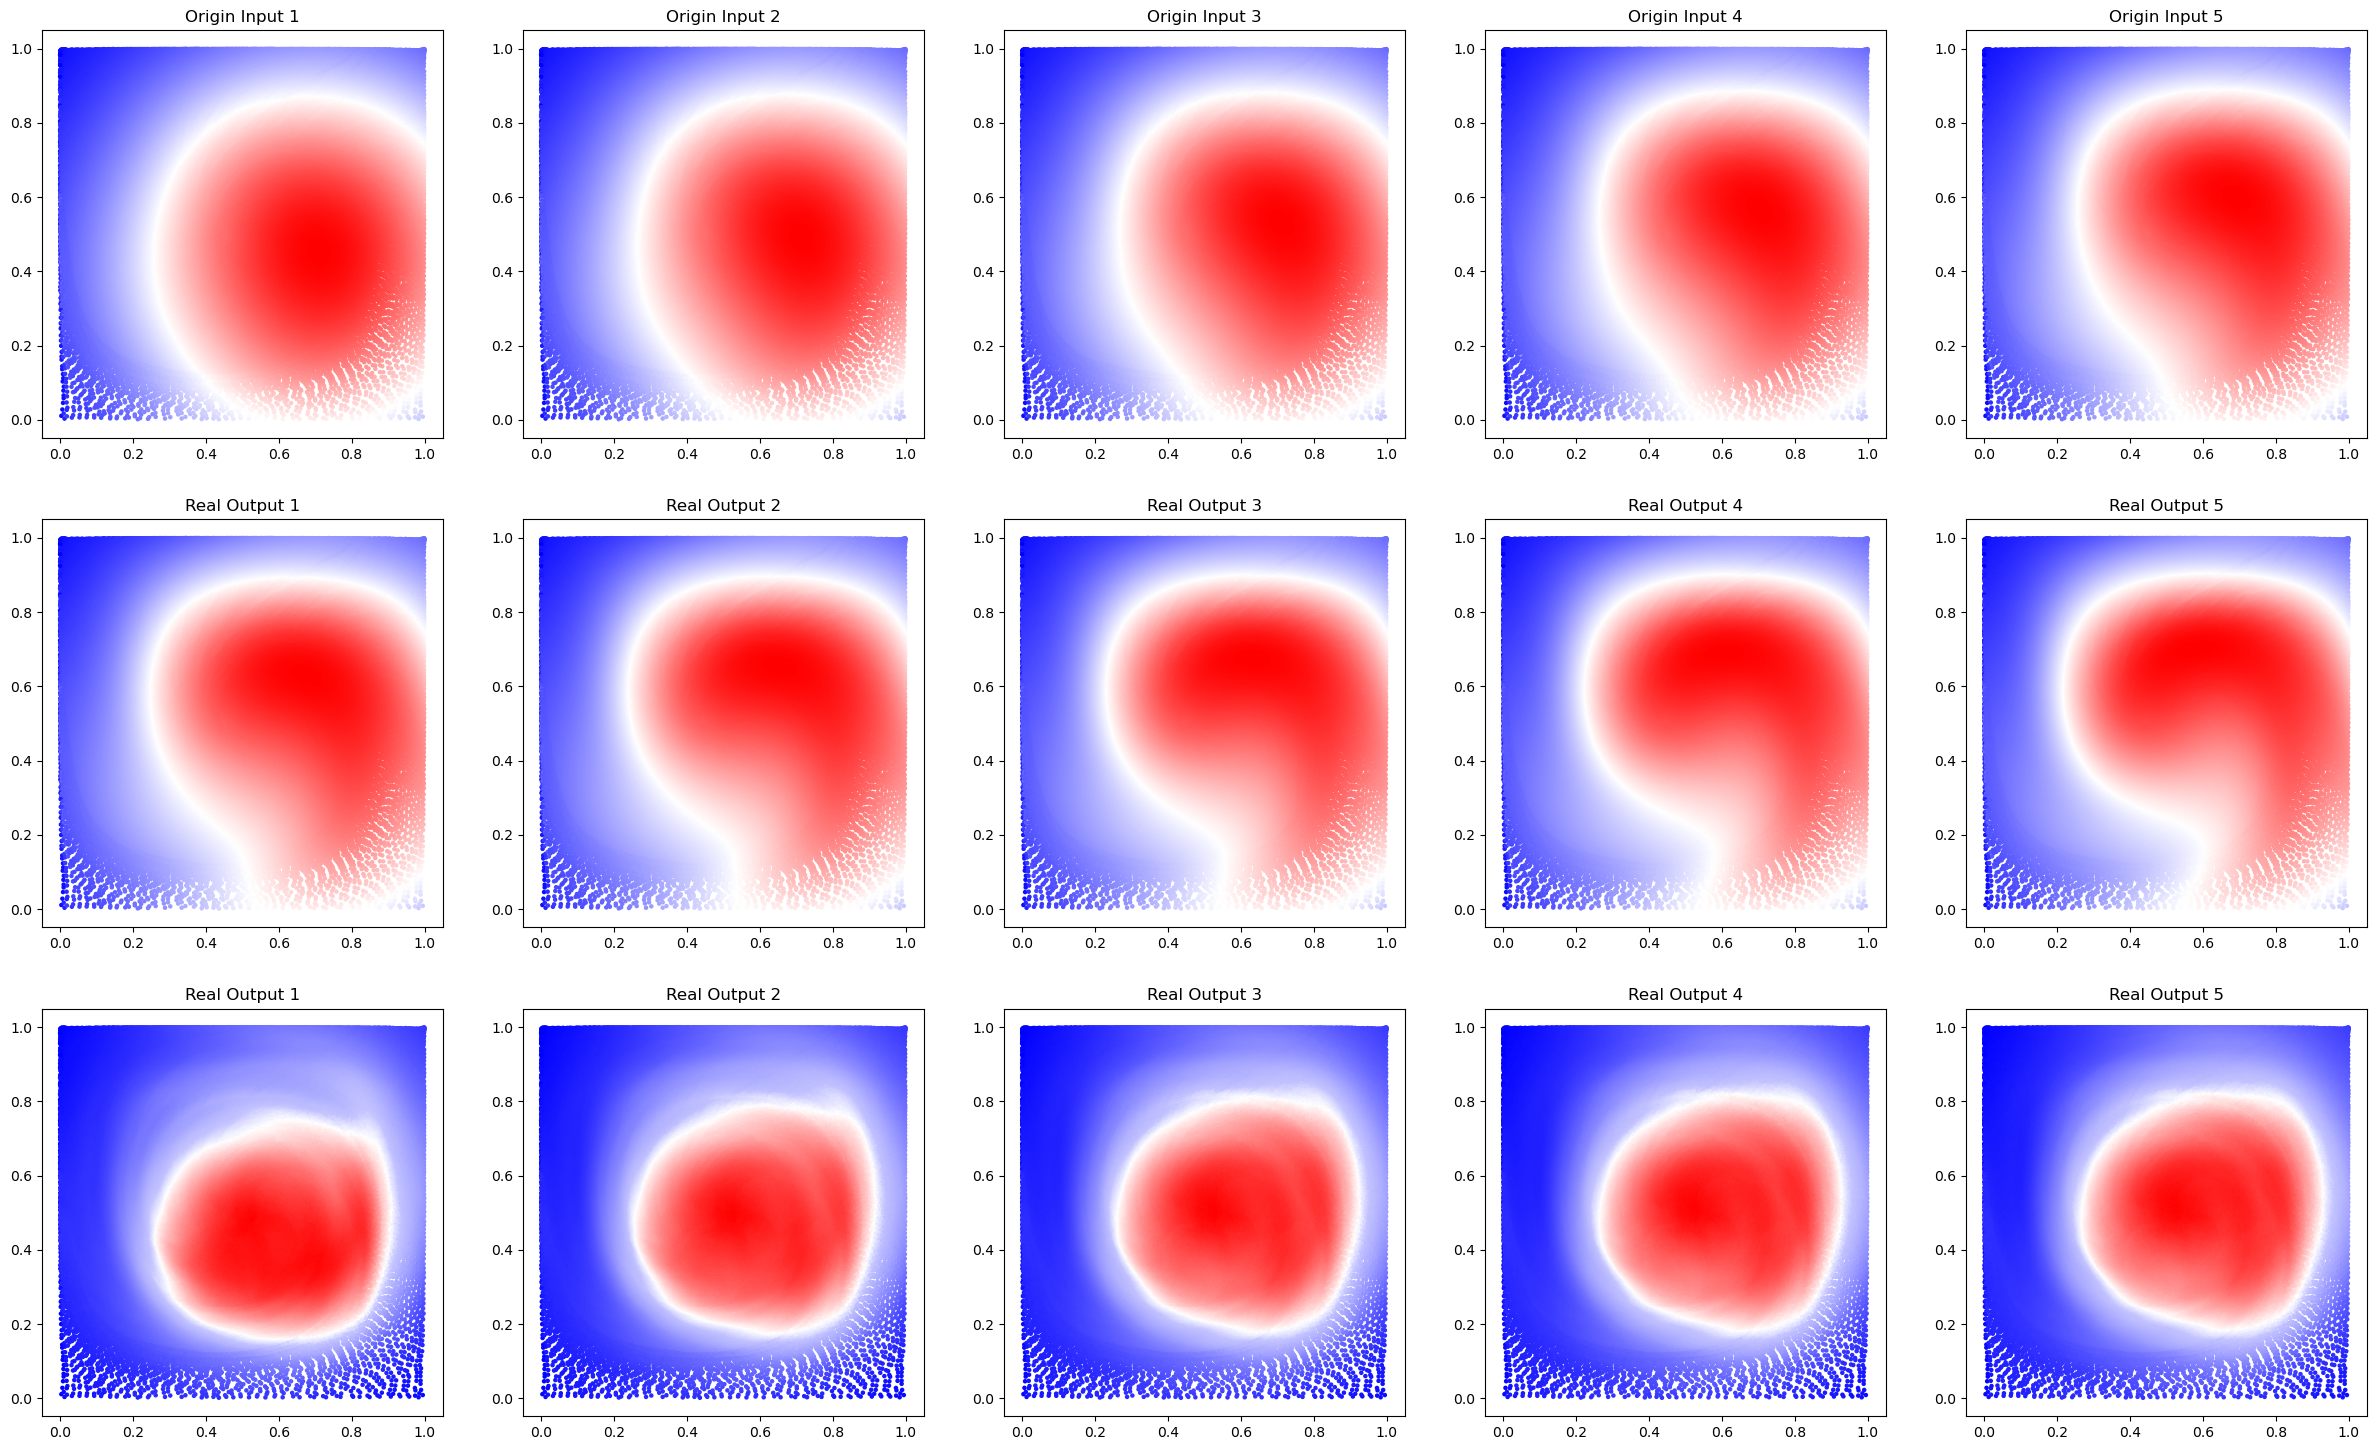

In [18]:
xyfile = "/home/wl4023/data/Sibo_22Mar2024/case_0/hessian_/xy_coords.npy"
coords = np.load(xyfile)

x, y = test_set[0]
predict = recon_predict_list[0]
draw_pic(x, y, predict, coords)